Import Some Material.....

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline

Import DataSet & copy it

In [2]:
Train_DF=pd.read_csv("auto-mpg.csv")
Train_OP_DF=Train_DF.copy()

In [3]:
Train_OP_DF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
Train_OP_DF["mpg"].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

In [5]:
Train_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [6]:
Train_OP_DF["horsepower"].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

We Have quision mark as null value so we should take care of it 

In [7]:
Train_OP_DF.loc[Train_OP_DF["horsepower"]=='?','horsepower']=0
Train_OP_DF["horsepower"]=Train_OP_DF["horsepower"].astype('int')
Train_OP_DF[Train_OP_DF["horsepower"]==0]
Train_OP_DF.loc[Train_OP_DF["horsepower"]==0,'horsepower']=np.NaN
Train_OP_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


Now we have real null value and I want to fill it with cylinders feature mean, First check the correlation between cylinders and horsepower

In [8]:
np.corrcoef(Train_OP_DF[~(Train_OP_DF["horsepower"].isna())]["cylinders"],
            Train_OP_DF[~(Train_OP_DF["horsepower"].isna())]["horsepower"])[0,1]

0.8429833569186557

So they have very good correaltion and we can fill horsepower missing value base on it 

In [9]:
Train_OP_DF["horsepower"].fillna(Train_OP_DF.groupby("cylinders")["horsepower"].transform("median"),inplace=True)

Let's convert Cylinders to categorical

In [10]:
Map_dict={}
j=0
for i in sorted(Train_OP_DF["cylinders"].unique(),reverse=False):
    Map_dict[i]=j
    j+=1
Train_OP_DF["cylinders"]=Train_OP_DF["cylinders"].map(Map_dict)

Let's do some scaler on horsepower,weight,acceleration and displacement

In [11]:
col_names=[ "horsepower","weight","acceleration", "displacement"]
features=Train_OP_DF[col_names]
Scaler=StandardScaler().fit(features.values)
Train_OP_DF[col_names]=Scaler.transform(features.values)

In the next step , we want to extract brand name from car name and after that we convert it to categorical

Plz Note that beacuse of some misspelling of brand name we had to use MED(Minimum Edit Distance)

In [12]:
Train_OP_DF["Brand"]=Train_OP_DF["car name"].str.split(" ").str[0]

In [13]:
from fuzzywuzzy import process
Map_dict={}
j=0
step=0.25
for i in sorted(Train_OP_DF["Brand"].unique(),reverse=False):
        if(len(Map_dict.keys())>0):
                if process.extract(i,list(Map_dict.keys()))[0][1]>=80 :
                      Map_dict[i]=Map_dict[process.extract(i,Map_dict.keys())[0][0]]
                else:
                      Map_dict[i]=j
                      j+=step
        else:
                Map_dict[i]=j
                j+=step
Map_dict["vw"]=Map_dict["volkswagen"]
Train_OP_DF["Brand"]=Train_OP_DF["Brand"].map(Map_dict)

C:\Users\Kaveh\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


and also we want to do a same action for model year

In [14]:
Map_dict={}
j=0
step=0.5
for i in sorted(Train_OP_DF["model year"].unique(),reverse=False):
                Map_dict[i]=j
                j+=step
Train_OP_DF["model year"]=Train_OP_DF["model year"].map(Map_dict)

For origin we want to convert Origin to dummy variable

In [15]:
Train_OP_DF_Temp=pd.get_dummies(Train_OP_DF["origin"],drop_first=True)

In [16]:
Train_OP_DF=pd.concat([Train_OP_DF,Train_OP_DF_Temp],axis=1)

In [17]:
Train_OP_DF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,Brand,2,3
0,18.0,4,1.090604,0.676181,0.630870,-1.295498,0.0,1,chevrolet chevelle malibu,1.50,0,0
1,15.0,4,1.503514,1.590844,0.854333,-1.477038,0.0,1,buick skylark 320,0.75,0,0
2,18.0,4,1.196232,1.198845,0.550470,-1.658577,0.0,1,plymouth satellite,5.50,0,0
3,16.0,4,1.061796,1.198845,0.546923,-1.295498,0.0,1,amc rebel sst,0.00,0,0
4,17.0,4,1.042591,0.937513,0.565841,-1.840117,0.0,1,ford torino,3.00,0,0


In [18]:
Train_OP_DF=Train_OP_DF.rename(columns={2:"Origin_1",3:"Origin_2"})

In [19]:
Train_OP_DF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,Brand,Origin_1,Origin_2
0,18.0,4,1.090604,0.676181,0.630870,-1.295498,0.0,1,chevrolet chevelle malibu,1.50,0,0
1,15.0,4,1.503514,1.590844,0.854333,-1.477038,0.0,1,buick skylark 320,0.75,0,0
2,18.0,4,1.196232,1.198845,0.550470,-1.658577,0.0,1,plymouth satellite,5.50,0,0
3,16.0,4,1.061796,1.198845,0.546923,-1.295498,0.0,1,amc rebel sst,0.00,0,0
4,17.0,4,1.042591,0.937513,0.565841,-1.840117,0.0,1,ford torino,3.00,0,0


So Lets do some ML Works.First Feature Selection. For beginnig we used all features.

In [20]:
Train_X_columns=["cylinders","displacement","horsepower","weight","acceleration","origin","model year"]
Train_Y_columns=["labels"]
X_Train=Train_OP_DF[Train_X_columns]
Y_Train=Train_OP_DF["mpg"]

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
clf=DecisionTreeRegressor()
cv_result=cross_val_score(clf,X_Train,Y_Train,cv=10,scoring="neg_mean_squared_error")
np.mean((-cv_result)**(1/2))

3.8626933213662342

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid={'n_estimators':np.arange(10,400,30),'min_samples_leaf':np.arange(1,20)}
clf=RandomForestRegressor(random_state=21)
gridcv=GridSearchCV(clf,param_grid,cv=10,n_jobs=-1,scoring="neg_mean_squared_error")
gridcv.fit(X_Train,Y_Train)
(-gridcv.best_score_)**(1/2)


2.9454874439179113

In [26]:
gridcv.best_params_

{'min_samples_leaf': 1, 'n_estimators': 310}

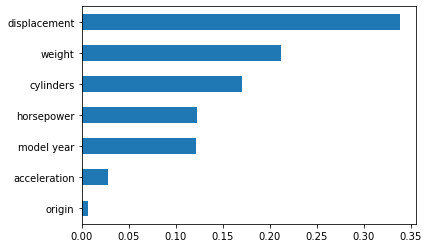

In [27]:
importance_rf=pd.Series(gridcv.best_estimator_.feature_importances_,index=X_Train.columns)
sorted_importance_rf=importance_rf.sort_values()
sorted_importance_rf.plot(kind="barh")

Now we Have great information about feature importances. let's eliminate some unnecessary features....

In [28]:
Train_X_columns=["cylinders","displacement","horsepower","weight","model year"]
Train_Y_columns=["labels"]
X_Train=Train_OP_DF[Train_X_columns]
Y_Train=Train_OP_DF["mpg"]

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid={'n_estimators':np.arange(10,400,30),'max_depth':np.arange(1,10)}
clf=GradientBoostingRegressor(random_state=21)
gridcv1=GridSearchCV(clf,param_grid,cv=10,n_jobs=-1,scoring="neg_mean_squared_error")
gridcv1.fit(X_Train,Y_Train)
(-gridcv1.best_score_)**(1/2)

2.9185378189908797

In [30]:
gridcv1.best_params_

{'max_depth': 2, 'n_estimators': 70}